# Merger models of blue supergiants 

Plots the period spacing and large frequency separation of merger models

by [Earl Patrick Bellinger](https://earlbellinger.com)$^{1,2,3}$

$^1$_Max Planck Institute for Astrophysics, Garching, Germany_ \
$^2$_Yale University, USA_ \
$^3$_Stellar Astrophysics Centre, Aarhus, Denmark_

In [1]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from scipy.signal import savgol_filter

from ipywidgets import interact, IntSlider

import seaborn as sns

import functools

import pickle

In [2]:
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse
from matplotlib.colors import BoundaryNorm, ListedColormap

In [3]:
from scipy.interpolate import UnivariateSpline

In [4]:
# Set plotting style 
sns.set(style="ticks", palette="muted", 
        rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('thinfig')

In [5]:
red = "#CA0020"
orange = "#F97100" 
blue = "#0571b0"

In [6]:
from mesagrid import Track, Grid

In [7]:
def load_history_extras(self, DF_):
    # period spacing
    delta_Pg_dict = {} 
    gyres = self.get_gyres()
    for i, gyre in enumerate(gyres):
        profile_number = self.index.profile_number[i]
        model_number = self.index.loc[self.index.profile_number == profile_number, 'model_number'].values[0]
        N  = gyre.N
        x  = gyre.r
        m  = gyre.m
        delta_Pg = 2*np.pi**2/np.sqrt(2)/ sp.integrate.trapz(N[N>0]/x[N>0], x[N>0])
        delta_Pg_dict[model_number] = delta_Pg
    DF_['delta_Pg'] = DF_['model_number'].map(delta_Pg_dict)
    
    self._gyres = None
    self._profiles = None
    
    # velocity in HRD 
    v_hr = np.sqrt(np.diff(DF_['log_L'])**2 + np.diff(DF_['log_Teff'])**2) / np.diff(DF_['star_age'])
    DF_['v_hr'] = np.concatenate(([np.nan], v_hr))
    
    return DF_


In [8]:
usecols_history = ['model_number', 'star_age', 'log_Teff', 'log_L', 'center_h1', 'center_he4', 
                   'delta_nu', 'delta_Pg']

In [9]:
grid_dirs = ["work/grid_normal", "work/grid_merge", "work/grid_semi"]
grid_normal, grid_merger, grid_semi = [
    Grid(dir, load_history_extras=load_history_extras,
                                usecols_history=usecols_history)
            for dir in grid_dirs]

In [10]:
grid_normal

100%|█████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 65165.74it/s]


Grid with 22 tracks
Columns: M, os, Z, Track
M     [10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17....
os                                         [0.335, 0.7]
Z                                                [0.02]
dtype: object

In [11]:
grid_merger

100%|█████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 52991.84it/s]


Grid with 20 tracks
Columns: M, mc, mg, Ye, Z, Track
M     [10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17....
mc                               [0.3, 0.25, 0.35, 0.5]
mg                               [0.0, 0.3, 0.15, 0.25]
Ye                                   [0.28, 0.31, 0.34]
Z                                                [0.02]
dtype: object

In [12]:
norm = mpl.colors.Normalize(vmin=-0.5, vmax=5.5)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greys_r)
vmin = int(norm.vmin)
vmax = int(norm.vmax)

In [13]:
with open('work/pkl/grid_normal.pkl', 'rb') as f:
    grid_normal = pickle.load(f)

In [14]:
with open('work/pkl/grid_merger.pkl', 'rb') as f:
    grid_merger = pickle.load(f)

In [15]:
grid_ = grid_normal.df[(grid_normal.df['os'] == 0.7) & (grid_normal.df['Z'] == 0.02)]
c = np.nanmin(grid_.loc[grid_['M'].idxmin()]['Track'].history.v_hr)
c

3.985362587216144e-09

# Plot

In [16]:
def get_data_points(DF_, label):
    if DF_.center_he4[0] > 0.5: # merger
        DF_ = DF_[DF_.center_he4 < 0.95]
    else:
        DF_ = DF_[DF_.center_h1 <= 0.7]
    
    if DF_.empty:
        return []
        
    DF_ = DF_[10**DF_.log_Teff <= 20000]
    DF_ = DF_[10**DF_.log_Teff >= 10000]
    
    if DF_.empty:
        return []
    
    if label == 'H Shell' or label == 'Blue Loop':
        DF_ = DF_[DF_.center_h1 <= 0.0001]
    elif label == 'H Core':
        DF_ = DF_[DF_.center_h1 >= 0.01]
    
    if DF_.empty:
        return []
    
    if label == 'Merger' or label == 'H Core' or label == 'Blue Loop':
        DF_ = DF_[DF_.v_hr/c < 100]
    
    if DF_.empty:
        return []
    
    #return list(zip(DF_['delta_nu'], DF_['delta_Pg']/60, DF_['star_age']))
    return pd.DataFrame({'delta_nu': DF_['delta_nu'], 
                         'delta_Pg': DF_['delta_Pg']/60, 
                         'star_age': DF_['star_age']})

In [17]:
def plot_data(points, color, label):
    if len(points) == 0:
        return 
    x = points.delta_nu.values
    y = points.delta_Pg.values
    plt.plot(x, y, c='lightgray', lw=1, zorder=-999)
    plt.scatter(x, y, s=25, color=color)#, alpha=0.8)
    plt.scatter(x[0], y[0], s=5, color='k', zorder=99)#, alpha=0.8)

In [18]:
def add_labels(xlim = [0.5, 20], ylim = [10, 500]):
    plt.text(1.1, 50, 'He Core', size=20, color='k')
    plt.text(1.2, 130, 'H Core', size=20, color='k')
    
    plt.semilogx()
    plt.semilogy()
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.gca().set_xticks([1, 2, 5, 10])
    plt.gca().set_xticklabels(['1', '2', '5', '10'])
    plt.gca().set_yticks([10, 50, 100, 500])
    plt.gca().set_yticklabels(['10', '50', '100', '500'])
    
    plt.xlabel(r'Large frequency separation $\mathbf{\Delta\nu/\mu}$Hz')
    plt.ylabel(r'Period spacing $\mathbf{\Delta\Pi/}$min')

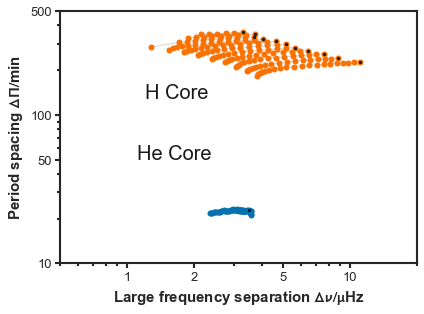

In [19]:
colors = [orange, blue]
labels = ['H Core', 'Merger']

plt.figure(figsize=(8*(4/5),6.5*(4/5)*(7/8)))
plt.gca().set_rasterization_zorder(-1)

grid = grid_normal.filter({'os': 0.7, 
                           'Z': 0.02})

for row in grid.itertuples():
    DF_ = row.Track.history
    points = get_data_points(DF_, labels[0])
    plot_data(points, colors[0], labels[0])

grid = grid_merger.filter({'mc': 0.3, 
                           'Z': 0.02, 
                           'mg': 0.3,#'mg': 0, 
                           'Ye': 0.28,
                           'M': [10, 15, 20]})

for row in grid.itertuples():
    DF_ = row.Track.history
    points = get_data_points(DF_, labels[1])
    plot_data(points, colors[1], labels[1])

add_labels()
#add_ellipses()
#plt.savefig('figs/astero.pdf')

In [20]:
with open('work/pkl/grid_normal.pkl', 'wb') as f:
    pickle.dump(grid_normal, f)

In [21]:
colors = [orange, blue]
labels = ['H Core', 'Merger']

def plot_normal(color='k'):#colors[0]):
    grid = grid_normal.df[(grid_normal.df['os'] == 0.7)  & 
                          (grid_normal.df['Z']  == 0.02)]
    plot_astero_normal(grid, color, labels[0])

def plot_astero_normal(grid, color='k', label=labels[1]):
    for row in grid.itertuples():
        DF_ = row.Track.history
        points = get_data_points(DF_, label)
        if len(points) > 2:
            x, y, star_age = points['delta_nu'], points['delta_Pg'], points['star_age']
            spl_x = UnivariateSpline(star_age, x, s=0.5)
            spl_y = UnivariateSpline(star_age, y, s=0.5)
            star_age_new = np.linspace(min(star_age), max(star_age), 1000)
            x_new = spl_x(star_age_new)
            y_new = spl_y(star_age_new)
            plt.plot(x_new, y_new, c=color, lw=3, zorder=999)

def plot_astero(grid, color_variable='M', label=labels[1], cmap='coolwarm'):
    min_color = grid[color_variable].min() 
    max_color = grid[color_variable].max()
    norm = Normalize(vmin=min_color, vmax=max_color)
    
    for row in grid.itertuples():
        DF_ = row.Track.history
        points = get_data_points(DF_, label)
        if len(points) > 0:
            color = cm.get_cmap(cmap)(norm(getattr(row, color_variable)))#*len(points)
            x, y, star_age = points['delta_nu'], points['delta_Pg'], points['star_age']#zip(*points)
            
            #spl_x = UnivariateSpline(star_age, x, s=0.5)
            #spl_y = UnivariateSpline(star_age, y, s=0.5)
            
            #star_age_new = np.linspace(min(star_age), max(star_age), 1000)
            #x_new = spl_x(star_age_new)
            #y_new = spl_y(star_age_new)
            
            plt.plot(points['delta_nu'], points['delta_Pg'], c=color, lw=3)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    cb = plt.colorbar(sm, label=label, ax=plt.gca())
    cb.set_ticks([min_color, max_color])
    
    #plt.grid()

In [22]:


cmap = ListedColormap([red, "#888888", blue])
def plot_astero(grid, color_variable='M', label=labels[1], cmap=cmap):
    
    boundaries = np.linspace(grid[color_variable].min(), grid[color_variable].max(), 4)
    norm = BoundaryNorm(boundaries, cmap.N)
    
    for row in grid.itertuples():
        DF_ = row.Track.history
        points = get_data_points(DF_, label)
        if len(points) > 0:
            color = cmap(norm(getattr(row, color_variable)))#*len(points)
            #x, y, star_age = points['delta_nu'], points['delta_Pg'], points['star_age']#zip(*points)
            
            #spl_x = UnivariateSpline(star_age, x, s=1)
            #spl_y = UnivariateSpline(star_age, y, s=1)
            
            #star_age_new = np.linspace(min(star_age), max(star_age), 1000)
            #x_new = spl_x(star_age_new)
            #y_new = spl_y(star_age_new)
            
            plt.plot(points['delta_nu'], points['delta_Pg'], c=color, lw=5, alpha=0.9)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    cb = plt.colorbar(sm, label=label, ax=plt.gca())
    
    # Set the ticks at parameter values instead of boundaries
    param_values = param_changes[color_variable]  # Make sure param_changes is accessible within this function
    cb.set_ticks(param_values)
    
    #plt.grid()


In [23]:
from matplotlib.lines import Line2D
colors = [red, "k", blue] # specify your colors

def plot_astero(grid, color_variable='M', label=labels[1]):
    color_values = np.unique(grid[color_variable])  # unique color variable values
    for row in grid.itertuples():
        DF_ = row.Track.history
        points = get_data_points(DF_, label)
        if len(points) > 0:
            color_var = getattr(row, color_variable)
            color = colors[np.where(color_values == color_var)[0][0]] # assign color based on color_variable value
            
            #x, y, star_age = points['delta_nu'], points['delta_Pg'], points['star_age']
            
            #spl_x = UnivariateSpline(star_age, x, s=1)
            #spl_y = UnivariateSpline(star_age, y, s=1)
            
            #star_age_new = np.linspace(min(star_age), max(star_age), 1000)
            #x_new = spl_x(star_age_new)
            #y_new = spl_y(star_age_new)
            
            plt.plot(points['delta_nu'], points['delta_Pg'], c=color, lw=5, alpha=0.9)
            
    # Creating custom legend
    custom_lines = [Line2D([0], [0], color=clr, lw=3) for clr in colors]
    
    # Modify labels
    labels = [str(int(val)) if val.is_integer() else str(val) for val in color_values]
    
    plt.legend(custom_lines, labels, title=label, loc='lower right')

    #plt.grid()


/tmp/ipykernel_2760/3797131030.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, i+1)


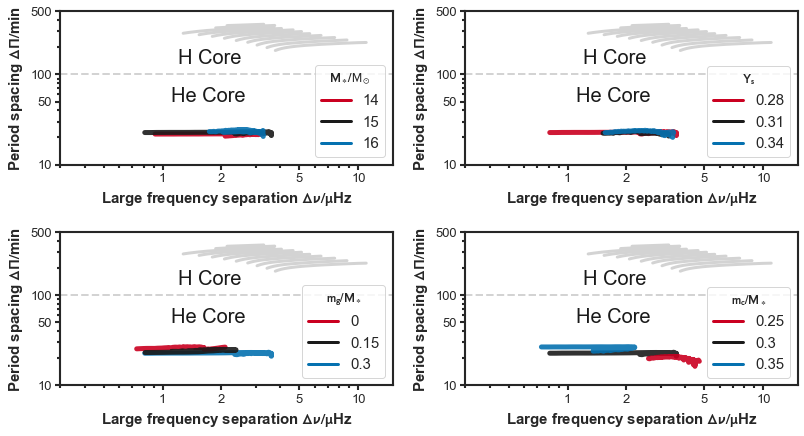

In [24]:
default_dict = {'mc': 0.3, 'Z': 0.02, 'mg': 0.3, 'Ye': 0.28, 'M': 15}
param_changes = {'M': [14, 15, 16], 'Ye': [0.28, 0.31, 0.34], 'mg': [0, 0.15, 0.3], 'mc': [0.25, 0.3, 0.35]}
param_labels = {'M': r'$\mathbf{M_\ast/\rm{M}}_\odot}$', 'Ye': r'$\mathbf{Y_s}$', 
                'mg': r'$\mathbf{m_g/M_\ast}$', 'mc': r'$\mathbf{m_c/M_\ast}$'}
param_titles = {'M': 'Stellar mass', 'Ye': 'Envelope helium', 'mg': 'Gradient mass', 'mc': 'Core mass'}

plt.figure(figsize=(8*(4/5)*2*0.9,6.4))
plt.gca().set_rasterization_zorder(-1)

for i, param in enumerate(['M', 'Ye', 'mg', 'mc']):
    plt.subplot(2, 2, i+1)
    plot_normal(color='lightgray')
    
    add_labels(xlim=[0.3, 15], ylim=[10, 500])
    plt.axhline(100, ls='--', c='lightgray')
    params = default_dict.copy()
    params[param] = param_changes[param]
    plot_astero(grid_merger.filter(params), color_variable=param, label=param_labels[param])
    #plt.title(param_titles[param], weight='bold')

plt.tight_layout();
plt.savefig('figs/astero.pdf')

In [25]:
with open('work/pkl/grid_merger.pkl', 'wb') as f:
    pickle.dump(grid_merger, f)